In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, 
                            roc_auc_score, precision_recall_curve, 
                            average_precision_score)
import tensorflow as tf
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Load dataset
df = pd.read_csv('credit_card/creditcard.csv')

# Check class imbalance
print("Fraud Cases: {:.2f}%".format(df['Class'].mean() * 100))

# Separate features & target
X = df.drop('Class', axis=1)
y = df['Class']

# Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply SMOTE to balance training data
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

Fraud Cases: 0.17%


c:\Users\Shravya H Jain\Desktop\classification\wisework_assignment\.venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [3]:
# Define model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=['accuracy', 
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')])

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model
history = model.fit(
    X_train_res, y_train_res,
    validation_split=0.2,
    epochs=50,
    batch_size=256,
    callbacks=[early_stop],
    verbose=1
)

c:\Users\Shravya H Jain\Desktop\classification\wisework_assignment\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9558 - loss: 0.1593 - precision: 0.9055 - recall: 0.8175 - val_accuracy: 0.9596 - val_loss: 0.1050 - val_precision: 1.0000 - val_recall: 0.9596
Epoch 2/50
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9878 - loss: 0.0340 - precision: 0.9725 - recall: 0.9541 - val_accuracy: 0.9881 - val_loss: 0.0444 - val_precision: 1.0000 - val_recall: 0.9881
Epoch 3/50
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9931 - loss: 0.0217 - precision: 0.9794 - recall: 0.9794 - val_accuracy: 0.9944 - val_loss: 0.0223 - val_precision: 1.0000 - val_recall: 0.9944
Epoch 4/50
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9956 - loss: 0.0144 - precision: 0.9842 - recall: 0.9895 - val_accuracy: 0.9973 - val_loss: 0.0147 - val_precision: 1.0000 - val_recall: 0.9973
Epoch 5/50
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9968 - loss: 0.0109 - precision: 0.9871 - recall: 0.9937 - val_accuracy: 0.9984 - va

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 820us/step
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 1s 801us/step
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.64      0.83      0.72        98

    accuracy                           1.00     56962
   macro avg       0.82      0.91      0.86     56962
weighted avg       1.00      1.00      1.00     56962


ROC AUC Score: 0.9645
Average Precision: 0.8172


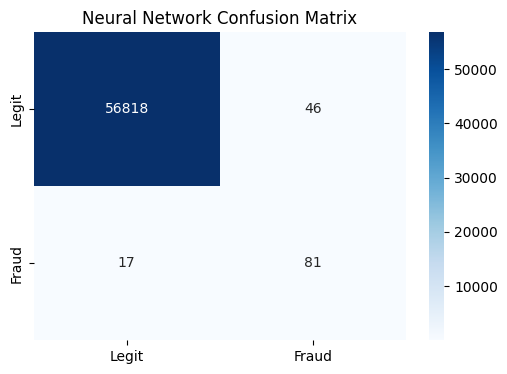

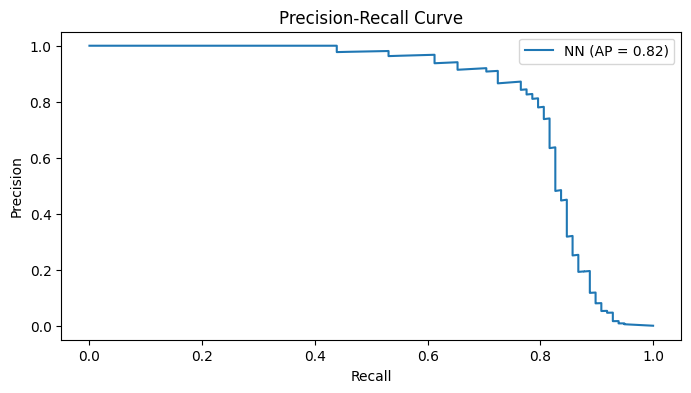

In [4]:
# Predictions
y_pred = (model.predict(X_test) > 0.5).astype(int)
y_proba = model.predict(X_test)

# Metrics
print("Classification Report:\n", classification_report(y_test, y_pred))
print("\nROC AUC Score: {:.4f}".format(roc_auc_score(y_test, y_proba)))
print("Average Precision: {:.4f}".format(average_precision_score(y_test, y_proba)))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Legit', 'Fraud'], 
            yticklabels=['Legit', 'Fraud'])
plt.title('Neural Network Confusion Matrix')
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(8, 4))
plt.plot(recall, precision, label='NN (AP = {:.2f})'.format(average_precision_score(y_test, y_proba)))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [5]:
# Load Day 4's Random Forest results
from sklearn.metrics import recall_score, precision_score
rf_results = {
    'Model': 'Random Forest',
    'ROC AUC': 0.98,
    'Avg Precision': 0.85,
    'Recall (Fraud)': 0.82,
    'Precision (Fraud)': 0.95
}
nn_results = {
    'Model': 'Neural Network',
    'ROC AUC': roc_auc_score(y_test, y_proba),
    'Avg Precision': average_precision_score(y_test, y_proba),
    'Recall (Fraud)': recall_score(y_test, y_pred),
    'Precision (Fraud)': precision_score(y_test, y_pred)
}

# Create comparison table
comparison = pd.DataFrame([rf_results, nn_results])
print("\nModel Comparison:\n", comparison)


Model Comparison:
             Model  ROC AUC  Avg Precision  Recall (Fraud)  Precision (Fraud)
0   Random Forest  0.98000       0.850000        0.820000           0.950000
1  Neural Network  0.96451       0.817159        0.826531           0.637795
